In [1]:
# ####################################
# Settings & Imports
# ####################################

# Imports from __future__ in case we're running Python 2
from __future__ import division, print_function
from __future__ import absolute_import, unicode_literals

# import my own helper functions
from read import read_sims_result
from clean import cleanup_0IR_exp
from clean import cleanup_0IR_single

# import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# import logistic regression from scikit learn 
from sklearn.linear_model import LogisticRegression

# import model selection stuff from scikit learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# import feature selection stuff from scikit learn
from sklearn.feature_selection import RFE

# sklearn.metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import brier_score_loss

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
# %config InlineBackend.figure_formats = {'png', 'retina'}

# remove some pandas warning
pd.options.mode.chained_assignment = None

In [2]:
# independent variables (candidates)
independent = ["deposits", "cash", "assets", "credit available", "wealth", "leverage", 
         "dummy-0-leverage",
         "wealth-lag", "deposits-lag", "cash-lag", "assets-lag", "leverage-lag", 
         "credit-available-lag", "credit-issued-lag", "dummy-0-leverage-lag",
         "over-leverage-frequency"]
# dependent variable 0
dependent = "default-next"

In [7]:
# ####################################
# Read input, toggle env variable here
# ####################################
train_on_file = "0614/0IR"
df = read_sims_result("/Users/xcheng/Documents/Oberlin/Summer2/DataAnalysis/data/"+train_on_file, 32)
inv_reg_strength = 0.007

In [8]:
# ################################
# Prepare to predict & write to file
# ################################

for cases in range(50,51,1):
    df2 = cleanup_0IR_exp(df, numNode=32, numPeriod=15, numSim=cases, balanced=True)

    X = df2[independent]
    y = df2[dependent]

    # Fit the model on all data
    final = LogisticRegression(penalty="l1", C=inv_reg_strength)
    final.fit(X,y)

    for ir in range(1,3,1):
        predict_on_file = "0719/" + str(ir) + "IR100s"
        df_1 =  read_sims_result("/Users/xcheng/Documents/Oberlin/Summer2/DataAnalysis/data/"+predict_on_file, 32)
        df_1c = cleanup_0IR_exp(df_1, numNode=32, numPeriod=15, numSim=100, balanced=False)

        accuracy_to_file = final.score(df_1c[independent], df_1c[dependent])
        brier_to_file = brier_score_loss(df_1c[dependent], final.predict(df_1c[independent]))
        confusion_to_file = confusion_matrix(df_1c[dependent], final.predict(df_1c[independent]))

        o_string = "\n{:d},{:s},{:f},{:s},{:f},{:f},{:f},{:f},{:d},{:d},{:d},{:d}".format(
                        len(df2),
                        train_on_file,
                        inv_reg_strength,
                        predict_on_file,
                        accuracy_to_file,
                        brier_to_file,
                        confusion_to_file[1,1]/(confusion_to_file[1,1]+confusion_to_file[0,1]), # precision
                        confusion_to_file[1,1]/(confusion_to_file[1,1]+confusion_to_file[1,0]), # recall
                        confusion_to_file[1,1], # true positive
                        confusion_to_file[1,0], # false negative
                        confusion_to_file[0,0], # true negative
                        confusion_to_file[0,1], # false positive
                    )

        with open("/Users/xcheng/Documents/Oberlin/Summer2/DataAnalysis/prediction.csv", "a") as f:
            f.write(o_string)

Now we need to analyze the data we have generated.

In [9]:
predictions = pd.read_csv("/Users/xcheng/Documents/Oberlin/Summer2/DataAnalysis/prediction.csv")

In [10]:
from scipy.stats.stats import pearsonr
print(pearsonr(predictions["size of training"], predictions["accuracy"]))
print(pearsonr(predictions["size of training"], predictions["precision"]))
print(pearsonr(predictions["size of training"], predictions["recall"]))

(-0.14035936913397437, 0.08252346490316503)
(-0.24502801688989642, 0.0021929656761366877)
(0.14763810933290408, 0.06766365693162638)


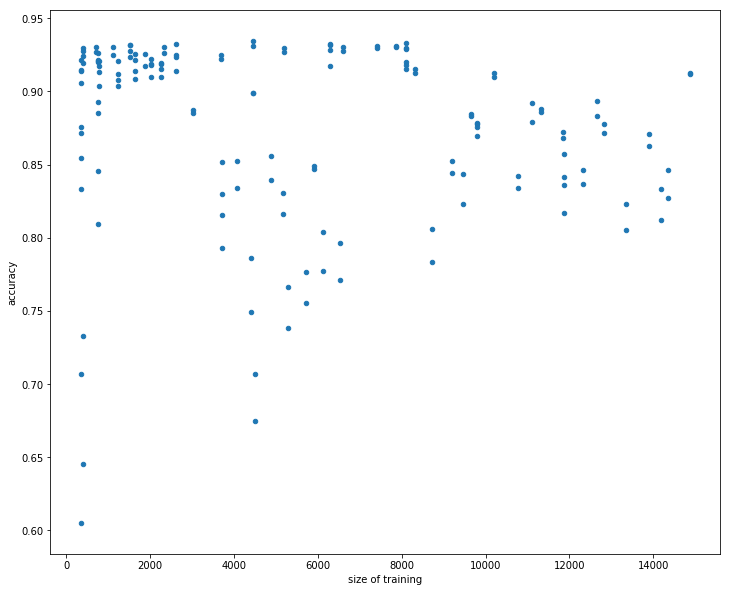

In [11]:
predictions.plot(x="size of training", y="accuracy", kind="scatter", figsize=(12,10))

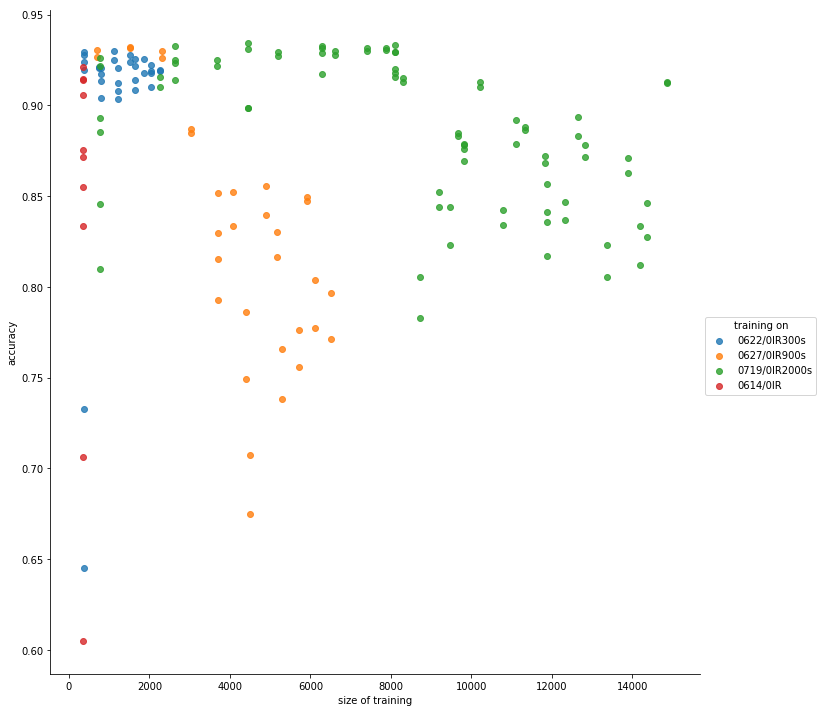

In [15]:
gt = sns.lmplot("size of training",
                "accuracy",
                data=predictions,
                hue='training on',
                legend_out=True,
                fit_reg=False,
                size=10
               )

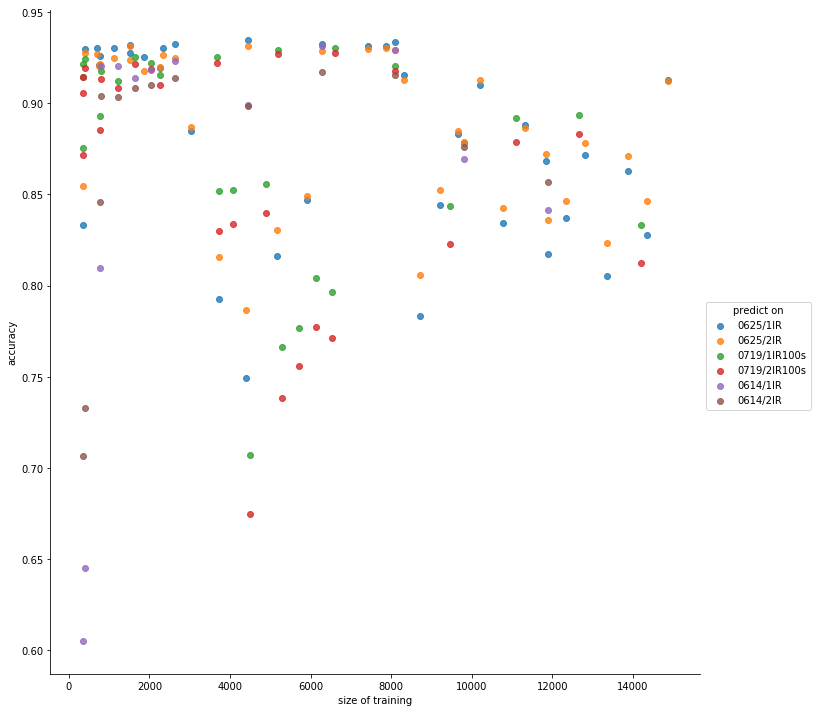

In [16]:
sns.lmplot("size of training", 
           "accuracy", 
           data=predictions, 
           hue='predict on', 
           fit_reg=False,
           size=10
          )